# WoS XML dataset exploration
Got access to MSU's copy of the XML dataset! Let's read in a file from a smaller year to get a sense of how to work with the data.

In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
from os import listdir
from os.path import abspath, splitext
from tqdm import tqdm

## XML dataset structure

The general jist of the organization is in this figure from the docs:

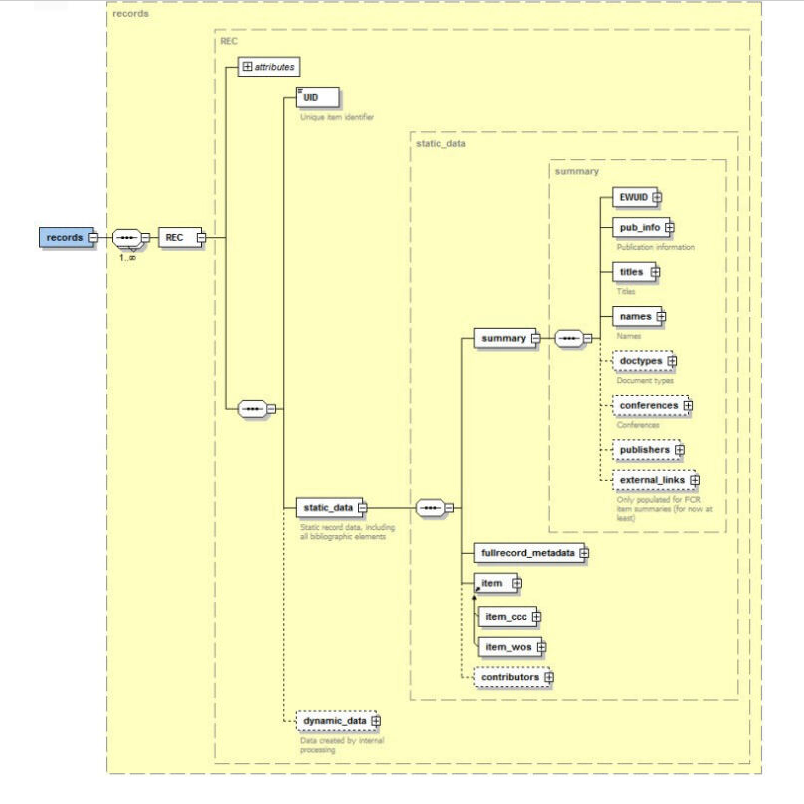

Let's write some code to wrangle out the papers we want into a single XML that we can later cast to jsonl when we want to use it with the code we already have.

In [70]:
tree = ET.parse('/mnt/scratch/lotrecks/WR_1900_20230801074843_CORE_0001.xml')

In [3]:
def get_uids(xml):
    """
    Get the UIDs present in a dataset.
    
    parameters:
        xml, ElementTree: dataset to parse
        
    returns:
        uids, list of str: UIDs
    """
    uids = []
    for record in xml.getroot():
        for uid in record.findall('{http://clarivate.com/schema/wok5.30/public/FullRecord}UID'):
            uids.append(uid.text)
    return uids

In [41]:
uids = get_uids(tree)
uids[:5]

['WOS:000201779900016',
 'WOS:000200918000050',
 'WOS:000200917700056',
 'WOS:000200917900028',
 'WOS:000200918200001']

In [223]:
# Print dataset tags in static_data
for paper in tree.getroot():
    for cat in paper:
        print('\n\n\nCATEGORY: ', cat.tag)
        for child in cat:
            print('\n')
            print(child.tag)
            print('-------------------------')
            for newchild in child:
                print(newchild.tag)

    break




CATEGORY:  {http://clarivate.com/schema/wok5.30/public/FullRecord}UID



CATEGORY:  {http://clarivate.com/schema/wok5.30/public/FullRecord}static_data


{http://clarivate.com/schema/wok5.30/public/FullRecord}summary
-------------------------
{http://clarivate.com/schema/wok5.30/public/FullRecord}EWUID
{http://clarivate.com/schema/wok5.30/public/FullRecord}pub_info
{http://clarivate.com/schema/wok5.30/public/FullRecord}titles
{http://clarivate.com/schema/wok5.30/public/FullRecord}names
{http://clarivate.com/schema/wok5.30/public/FullRecord}doctypes
{http://clarivate.com/schema/wok5.30/public/FullRecord}publishers


{http://clarivate.com/schema/wok5.30/public/FullRecord}fullrecord_metadata
-------------------------
{http://clarivate.com/schema/wok5.30/public/FullRecord}languages
{http://clarivate.com/schema/wok5.30/public/FullRecord}normalized_languages
{http://clarivate.com/schema/wok5.30/public/FullRecord}normalized_doctypes
{http://clarivate.com/schema/wok5.30/public/FullRecord}ref

In [10]:
def convert_xml_reference(ref):
    """
    Convert a reference.
    
    parameters:
        ref, ElementTree: reference to convert
        
    returns:
        ref_json, dict: formatted ref
    """
    ref_json = {}
    # UID
    for uid in ref.findall('{http://clarivate.com/schema/wok5.30/public/FullRecord}uid'):
        ref_json['UID'] = uid.text
    # Year
    for year in ref.findall('{http://clarivate.com/schema/wok5.30/public/FullRecord}year'):
        ref_json['year'] = year.text
    # Title
    for title in ref.findall('{http://clarivate.com/schema/wok5.30/public/FullRecord}citedTitle'):
        ref_json['title'] = title.text

    return ref_json

In [28]:
def convert_xml_paper(paper):
    """
    Convert a single paper from WoS XML to json.
    
    parameters:
        paper, ElementTree: child of XML dataset to convert

    returns:
        paper_json, dict: paper in json format
    """
    paper_json = {}
    
    # UID
    for uid in paper.findall('{http://clarivate.com/schema/wok5.30/public/FullRecord}UID'):
        paper_json['UID'] = uid.text
    
    for static in paper.findall('{http://clarivate.com/schema/wok5.30/public/FullRecord}static_data'):
        for summary in static.findall('{http://clarivate.com/schema/wok5.30/public/FullRecord}summary'):
            # Title
            for titles in summary.findall('{http://clarivate.com/schema/wok5.30/public/FullRecord}titles'):
                for title in titles:
                    if title.attrib['type'] == 'item':
                        paper_json['title'] = title.text
            # Year
            for pub_info in summary.findall('{http://clarivate.com/schema/wok5.30/public/FullRecord}pub_info'):
                paper_json['year'] = pub_info.attrib['pubyear']
        for fullrec in static.findall('{http://clarivate.com/schema/wok5.30/public/FullRecord}fullrecord_metadata'):
            # References
            refs_list = []
            for refs in fullrec.findall('{http://clarivate.com/schema/wok5.30/public/FullRecord}references'):
                for ref in refs:
                    refs_list.append(convert_xml_reference(ET.ElementTree(ref)))
            # Abstract
            for abstracts in fullrec.findall('{http://clarivate.com/schema/wok5.30/public/FullRecord}abstracts'):
                abstract_list = []
                for abstr in abstracts:
                    for ab in abstr:
                        for a in ab:
                            abstract_list.append(a.text)
                if len(abstract_list) > 1:
                    print(f'There are {len(abstract_list)} abstracts for this paper:')
                    print("\n\n".join(abstract_list))
                paper_json['abstract'] = abstract_list[0]
        paper_json['references'] = refs_list
        # Keywords
        static_keys = []
        for fullrec in static.findall('{http://clarivate.com/schema/wok5.30/public/FullRecord}fullrecord_metadata'):
            for category in fullrec.findall('{http://clarivate.com/schema/wok5.30/public/FullRecord}category_info'):
                for subjects in category.findall('{http://clarivate.com/schema/wok5.30/public/FullRecord}subjects'):
                    for subj in subjects:
                        static_keys.extend(subj.text.split())
        paper_json['static_keywords'] = static_keys
        # Dynamic subjects
        dynamic_keys = []
        for dynamo in paper.findall('{http://clarivate.com/schema/wok5.30/public/FullRecord}dynamic_data'):
            for cr in dynamo.findall('{http://clarivate.com/schema/wok5.30/public/FullRecord}citation_related'):
                for ct in cr.findall('{http://clarivate.com/schema/wok5.30/public/FullRecord}citation_topics'):
                    for subj_group in ct.findall('{http://clarivate.com/schema/wok5.30/public/FullRecord}subj-group'):
                        for subj in subj_group.findall('{http://clarivate.com/schema/wok5.30/public/FullRecord}subject'):
                            dynamic_keys.append(subj.text)
        paper_json['dynamic_keys'] = dynamic_keys

        return paper_json

In [9]:
def filter_xml_papers(xml, uids_to_keep):
    """
    Filter an XML dataset to include only papers from a given list and convert to jsonl. Also filters out non-English
    language papers.
    
    parameters:
        xml, ElementTree: dataset to parse
        uids_to_keep, list of str: UIDs to keep
    
    returns:
        paper_jsonl, list of dict: papers to keep in jsonl format
    """
    paper_jsonl = []
    for record in xml.getroot():
        in_uids = False
        in_english = False 
        # Check the UID
        for uid in record.findall('{http://clarivate.com/schema/wok5.30/public/FullRecord}UID'):
            if uid.text in uids_to_keep:
                in_uids = True
        # Check if the paper is in English
        for static in record.findall('{http://clarivate.com/schema/wok5.30/public/FullRecord}static_data'):
            for fullrec in static.findall('{http://clarivate.com/schema/wok5.30/public/FullRecord}fullrecord_metadata'):
                for langs in fullrec.findall('{http://clarivate.com/schema/wok5.30/public/FullRecord}normalized_languages'):
                    for lang in langs:
                        if lang.text == 'English':
                            in_english = True
        # Format
        if in_uids and in_english:
            paper_dict = convert_xml_paper(ET.ElementTree(record))
            paper_jsonl.append(paper_dict)

    return paper_jsonl

In [362]:
filter_xml_papers(tree, uids[:1])

[{'UID': 'WOS:000201779900016',
  'title': 'Stratified drift and deglaciation of eastern Washington',
  'year': '1936',
  'references': [{'UID': 'WOS:000201738600017',
    'year': '1933',
    'title': 'Terraces and Coulees along the Columbia River near Lake Chelan, Washigton'},
   {'UID': 'WOS:000201779900016.7', 'year': '1935'},
   {'UID': 'WOS:000201779900016.4', 'year': '1925'},
   {'UID': 'WOS:000201977100059',
    'year': '1922',
    'title': 'The glaciation of the Cordilleran region'},
   {'UID': 'WOS:000201779900016.10', 'year': '1918'},
   {'UID': 'WOS:000201779900016.6', 'year': '1935'},
   {'UID': 'WOS:000201779900016.5'},
   {'UID': 'WOS:000201779900016.2'},
   {'UID': 'WOS:000201779900016.3', 'year': '1920'},
   {'UID': 'WOS:000201779900016.11', 'year': '1932'},
   {'UID': 'WOS:000201779900016.12', 'year': '1901'},
   {'UID': 'WOS:000201779900016.8', 'year': '1924'},
   {'UID': 'WOS:000201779900016.13', 'year': '1915'},
   {'UID': 'WOS:000201779200022',
    'year': '1923',


That looks pretty good! It looks like not all of the references have titles, but I think that's because they aren't in the WOS database, from what I can tell from reading the docs. That tracks, because the UID for non-database sources is the same as the parent item but with a .# indicating what order it was cited in.

## Search results from browser
There isn't a way to search through the XML dataset, so we need to get the UID's of the papers we want from the GUI. First, let's try the Fast 5000 download option.

Field tag definitions for the headers of these df's can be found [here](https://images.webofknowledge.com/images/help/WOS/hs_wos_fieldtags.html)

In [13]:
search_res = pd.concat([pd.read_csv('../data/wos_files/destol_or_anhydro_WoSGUI_08Dec2023_0.txt', sep='\t', index_col=False),
                       pd.read_csv('../data/wos_files/destol_or_anhydro_WoSGUI_08Dec2023_1.txt', sep='\t', index_col=False),
                       pd.read_csv('../data/wos_files/destol_or_anhydro_WoSGUI_08Dec2023_2.txt', sep='\t', index_col=False)])

In [14]:
search_res.head()

,PT,AU,BA,CA,GP,RI,OI,BE,Z2,TI,...,TC,Z8,ZB,ZS,Z9,SN,BN,WC,UT,PM
0,J,"Osyczka, Piotr; Koscielniak, Robert; Stanek, M...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Old-growth forest versus generalist lichens: S...,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MEDLINE:38039398,NaN
1,J,"Sahu, Balram; Naithani, Subhash Chandra",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Role of reactive oxygen species and antioxidat...,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WOS:001102908100001,NaN
2,J,"Lopez-Pozo, M.; Fernandez-Marin, B.; Garcia-Pl...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ageing kinetics of fern chlorophyllous spores ...,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WOS:001083936800001,NaN
3,J,"Fleming, James F; Pisani, Davide; Arakawa, Kaz...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,The evolution of temperature and desiccation-r...,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MEDLINE:38019582,NaN
4,J,"Okemo, Pauline A; Njaci, Isaac; Kim, Young-Mo;...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tripogon loliiformis tolerates rapid desiccati...,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MEDLINE:37996547,NaN


In [364]:
search_res.to_csv('../data/wos_files/destol_or_anhydro_WoSGUI_08Dec2023_COMBINED.txt', sep='\t', index=False)

In [20]:
# Columns containing non-NaN values
not_nan = search_res.isnull().all()[~search_res.isnull().all()]

In [24]:
for col in not_nan.index:
    print(f'Snapshot of unique values for column {col}:')
    print(list(search_res[col].unique())[:10])
    print('\n\n\n')

Snapshot of unique values for column PT:
['J', 'P', 'B']




Snapshot of unique values for column AU:
['Osyczka, Piotr; Koscielniak, Robert; Stanek, Malgorzata', 'Sahu, Balram; Naithani, Subhash Chandra', 'Lopez-Pozo, M.; Fernandez-Marin, B.; Garcia-Plazaola, I. J.; Seal, C. E.; Ballesteros, D.', 'Fleming, James F; Pisani, Davide; Arakawa, Kazuharu', 'Okemo, Pauline A; Njaci, Isaac; Kim, Young-Mo; McClure, Ryan S; Peterson, Matthew J; Beliaev, Alexander S; Hixson, Kim K; Mundree, Sagadevan; Williams, Brett', 'Vecchi, M; Stec, D; Rebecchi, L; Michalczyk, L; Calhim, S', 'Lane, Jessica R.; Tata, Muralidhar; Yasmin, Rahena; Im, Hansol; Briles, David E.; Orihuela, Carlos J.', 'Ramirez, John F; Kumara, U G V S S; Arulsamy, Navamoney; Boothby, Thomas C', 'Bora, Leticia Siman; Padial, Andre Andrian', 'Arzac, Miren Irati; Miranda-Apodaca, Jon; Gasulla, Francisco; Arce-Guerrero, Maria; Fernandez-Marin, Beatriz; Garcia-Plazaola, Jose Ignacio']




Snapshot of unique values for column BA:
[nan, 'K

The headers with data in our dataset are `PT` = publication type, `AU` = authors, `BA` = book authors, `CA` = group authors, `GP` = group book authors, `TI` = title, `SO` = publication name, `VL` = volume, `IS` = issue, `BP` = beginning page, `EP` = ending page, `AR` = article number, `DI` = DOI, `PD` = publication date, `PY` = year published, `CT` = conference title, `CY` = conference date, `SP` = conference sponsors, `TC` = Web of Science Core Collection Times Cited Count, `UT` = accession number.

`UT` is what I want in order to link with theXML dataset; going to start combining the code I've written into a script so that I can do this efficiently.

## Checking types of UIDs present in dataset
Not all UIDs from the GUI are prefixed by `WOS:`, so let's see what other types exist in the XML dataset. Our code runs, but seems to exclude papers that don't have `WOS:` prefixes, so we'd like to see if that's just because they aren't included in the XML dataset.

In [8]:
all_uids = []
for f in tqdm(listdir('/mnt/scratch/lotrecks/Annuals/')):
    if splitext(f)[1] == '.xml':
        if f.split('_')[1] == '2010':
            tree = ET.parse(f'/mnt/scratch/lotrecks/Annuals/{f}')
            all_uids.extend(get_uids(tree))
            del tree

100%|██████████| 1032/1032 [31:05<00:00,  1.81s/it]


In [9]:
all_uids[:10]

['WOS:000273997500009',
 'WOS:000280245000004',
 'WOS:000276194400006',
 'WOS:000274446200008',
 'WOS:000279313900027',
 'WOS:000273662300015',
 'WOS:000271571000101',
 'WOS:000274503400022',
 'WOS:000277494400004',
 'WOS:000282303700013']

In [10]:
prefixes = set([u.split(':')[0] for u in all_uids])

In [11]:
prefixes

{'WOS'}

There are only WOS tags in the dataset. This means that either, papers are missing from this dataset that are accessible in the GUI search engine, or there is some kind of mapping of ID's. What happens if we ignore the tags? The UID we're missing in our toy example is `CABI:20103200131`, let's work with that one.

In [12]:
uid = 'CABI:20103200131'

In [13]:
no_prefix = [u.split(':')[1] for u in all_uids]

In [14]:
lens = set([len(u) for u in no_prefix])
lens

{15}

In [15]:
short_target = uid.split(':')[1]
len(short_target)

11

In [17]:
# Add 4 0's
short_target = '0000' + short_target
short_target

'000020103200131'

In [18]:
short_target in no_prefix

False

On further inspection, all non-WOS tags are excluded from the Core Collection, so I refined the original GUI search to only include the Core Collection.

## Getting abstracts
It turns out that there is an abstract field, it's just that the papers from the 1900s don't have it. However, the code I added to my script doesn't appear to be working, so let's take a look at an example where it failed. We also want to see if it's possible to get abstracts for the references or if we would need to go back over the dataset to get them from their original years.

In [2]:
tree = ET.parse('/mnt/scratch/lotrecks/Annuals/WR_2021_20230117130043_CORE_0020.xml')

In [4]:
uids_to_keep = ['WOS:000632934700003']

In [50]:
myjson = filter_xml_papers(tree, uids_to_keep)

In [51]:
myjson

[{'UID': 'WOS:000632934700003',
  'title': 'Culture-dependent and culture-independent characterization of bacterial community diversity in different types of sandy lands: the case of Minqin County, China',
  'year': '2021',
  'abstract': 'BackgroundMinqin is suffering from a serious desertification, whereas the knowledge about its bacterial community is limited. Herein, based on Nitraria tangutorum and Haloxylon ammodendron from Minqin, the bacterial community diversities in fixed sandy land, semi-fixed sandy land and shifting sandy land were investigated by combining with culture-dependent and culture-independent methods.ResultsMinqin stressed with high salinity and poor nutrition is an oligotrophic environment. Bacterial community in Minqin was shaped primarily by the presence of host plants, whereas the type of plant and sandy land had no marked effect on those, which displayed a better survival in the rhizospheres of N. tangutorum and H. ammodendron. The dominant groups at phyla le

## Getting dynamic keywords
Going to use the 2021 XML above to work on this.

In [4]:
uids_to_check = get_uids(tree)

In [6]:
uids_to_check = uids_to_check[:20]

In [29]:
filter_xml_papers(tree, uids_to_check)

There are 8 abstracts for this paper:
Background

Typically, colorectal liver metastasis (CRLM) is not a candidate for hepatectomy. Radiofrequency ablation (RFA) plays a critical role in unresectable CRLM patients. Nevertheless, high local tumor progression (LTP) and distant metastasis limit the development and further adoption and use of RFA. Neoadjuvant chemotherapy (NAC) has been widely used in resectable CRLM and is recommended by the guidelines. There are no studies on whether NAC can improve the prognosis in ablatable CRLM patients. The present study aimed to determine the feasibility and effectiveness of RFA plus NAC.

Methods

This retrospective cohort included CRLM patients from Zhejiang Cancer Hospital records, who received RFA from January 2009 to June 2020 and were divided into two groups according to the presence or absence of NAC. The Kaplan-Meier method was used to evaluate the 3-year local tumor progression-free survival (LTPFS), progression-free survival (PFS), and ove

[{'UID': 'WOS:000655535600007',
  'title': 'Improved solid phase extraction for selective and efficient quantification of sunset yellow in different food samples using a novel molecularly imprinted polymer reinforced by Fe3O4@UiO-66-NH2',
  'year': '2021',
  'abstract': 'The overuse of synthetic dyes in food products has gradually increased in recent years, resulting food safety and human health has become a global issue. An innovative design of a magnetic molecularly imprinted polymer (Fe3O4@UiO-66-NH2@MIP) for efficient, fast, and selective determination of sunset yellow (SY) from different food products was described in this study. The absorption properties of Fe3O4@UiO-66-NH2@MIP were elucidated by adsorption kinetics, isotherms, reusability, and selectivity experiments. Because of the incorporation of porous Fe3O4@UiO-66-NH2 nanocomposite into molecularly imprinted polymer an efficient nanosorbent with a short equilibrium time, a high adsorption capacity, and a good imprinting fac